In [3]:
import warnings
warnings.filterwarnings(action="ignore")

import os
import numpy as np
import pandas as pd

from tensorflow import keras

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

2024-03-22 20:59:37.710248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 20:59:37.710301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 20:59:37.711748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_dir = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images"
mask_dir = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks"

In [5]:
df = pd.read_csv("/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/meta_data.csv")

print(df.shape)

df.head()

(5108, 2)


,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [6]:
for col in df.columns:
    if col == "image":
        dir_1 = image_dir
    else:
        dir_1 = mask_dir
        
    for idx, img in enumerate(df[col]):
        df.loc[idx, col] = os.path.join(dir_1, img)

In [7]:
train, test = train_test_split(df, test_size=0.1)
test, val = train_test_split(test, test_size=0.1)

print(train.shape, test.shape, val.shape)

(4597, 2) (459, 2) (52, 2)


In [8]:
Xtrain = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224)))/255 for i in train["image"]])
ytrain = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224), color_mode="grayscale"))/255 for i in train["mask"]])
Xtest = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224)))/255 for i in test["image"]])
ytest = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224),color_mode="grayscale"))/255 for i in test["mask"]])
Xval = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224)))/255 for i in val["image"]])
yval = np.array([keras.utils.img_to_array(keras.utils.load_img(i, target_size=(224, 224), color_mode="grayscale"))/255 for i in val["mask"]])

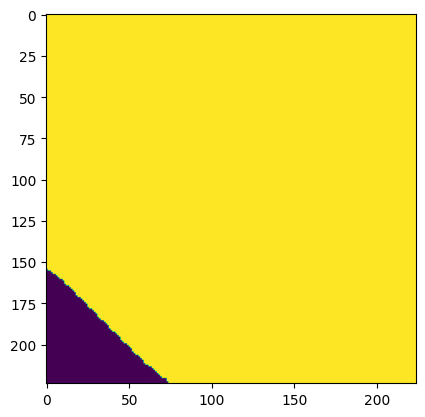

In [9]:
plt.imshow(yval[5])

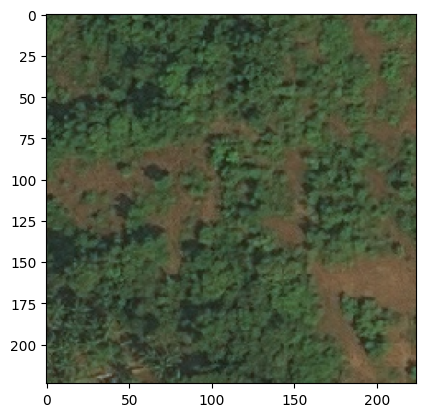

In [10]:
plt.imshow(Xval[5])

In [32]:
def conv_block(input_, num_filters):
    x = keras.layers.Conv2D(num_filters, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input_)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(num_filters, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    return x

def encoder_block(input_, num_filters):
    x = conv_block(input_, num_filters)
    p = keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input_, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(input_)
    x = keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = keras.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

In [33]:
model = build_unet((224, 224, 3))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              loss = ['binary_crossentropy'], 
              metrics=['accuracy'])

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 224, 224,  │        896 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 112, 112,  │     18,496 │ max_pooling2d_36… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 56, 56,    │     73,856 │ max_pooling2d_37… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 28, 28,    │    295,168 │ max_pooling2d_38

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [34]:
model_path = "unet.keras"
checkpoint = keras.callbacks.ModelCheckpoint(model_path,
                                             monitor="val_loss",
                                             mode="min",
                                             save_best_only = True,
                                             verbose=1)

earlystop = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                          min_delta = 0, 
                                          patience = 5,
                                          verbose = 1,
                                          restore_best_weights = True)

In [35]:
history = model.fit(Xtrain, ytrain,
#                     steps_per_epoch=len(train)//32,
                    validation_data=(Xtest, ytest),
#                     validation_steps=len(test)//32,
                    epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7288 - loss: 0.5660
Epoch 1: val_loss improved from inf to 6.29695, saving model to unet.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 309ms/step - accuracy: 0.7289 - loss: 0.5658 - val_accuracy: 0.3932 - val_loss: 6.2969
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7605 - loss: 0.4984
Epoch 2: val_loss did not improve from 6.29695
144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - accuracy: 0.7605 - loss: 0.4984 - val_accuracy: 0.3923 - val_loss: 11.1793
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7694 - loss: 0.4857
Epoch 3: val_loss improved from 6.29695 to 3.50288, saving model to unet.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.7694 - loss: 0.4857 - val_accuracy: 0.7342 - val_loss: 3.5029
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7796 - loss: 0.4661
Epoch 4: val_loss improved from 3.50288 to 2.35729, saving model to unet.keras
144/144

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


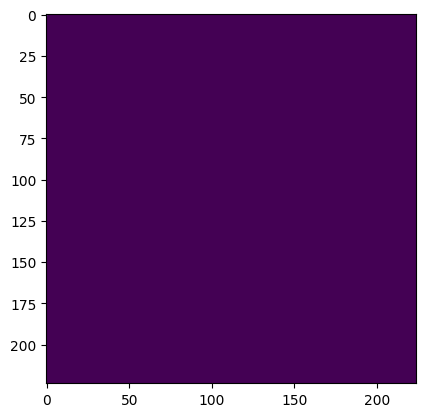

In [79]:
plt.imshow(model.predict(np.expand_dims(Xval[11], axis=0)).reshape(224, 224, 1))

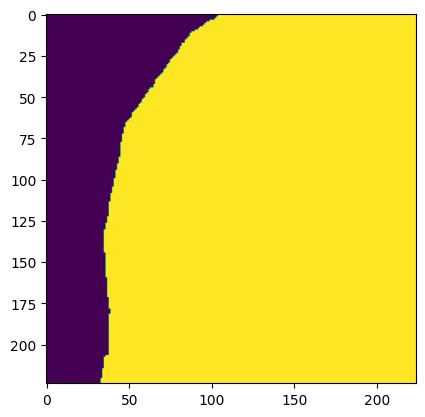

In [73]:
plt.imshow(yval[6])

## Observation:
* The bad performance of the model is due to bad labelling of the mask.